# Data Mining
### This notebook contains complete analysis of Image Classification of Person activities 
#### We have used CV2 library to do a basic analysis of Images 
##### Note : we did not use any deep learning techniques

### We are using below techniques in this notebook
1. Sobel for image filtering
2. SIFT for feature extraction


## Method followed to do the classification
### We have used Bag of Features technique to do the classfication of human activities
1. First we do the filtering process
2. Then we apply feature extraction techniques to extract descriptions of images
3. Then we apply K-Means clustering to group the features
4. Histograms are calculated for finding the count of each cluster
5. Then we different classifiers to do the prediction

In [15]:
import os
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import numpy as np

#For Model
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.svm import SVC
from sklearn import linear_model

#For ROC
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

%matplotlib inline

### Find one-hot encoding for different categories (Totally we have 10 classes)

In [16]:
categories = ["bend", "gallop_sideways", "jack", "jump", "jump_in_place", "one_hand", "run","skip", "two_hand", "walk"]
values = array(categories) #same as above array[]
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(values) #[0,1,2,3,4,5,6,7,8,9]
onehot_encoder = OneHotEncoder(sparse=True)
int_encoded = int_encoded.reshape(-1,1) #(10,1) matrix 
onehot_encoded = onehot_encoder.fit_transform(int_encoded) #(10,10) matrix, as taught by Andrew about Dummy Variables
#print(onehot_encoded)

### Extracting and creating the dataset

In [17]:
#Get paths for all images in Frames directory
def get_paths(directory="Frames"):
    #directory = "Frames"
    dataset_paths = []
    for action in os.listdir(directory): #action = 'Bend' 
        action_path = os.path.join(directory,action) #Frames//Bend
        for dir in os.listdir(action_path): # dir = Untitle Folder 1
            pic_dir_path = os.path.join(action_path,dir) #Frames//Bend//Untitled Folder 1
            for pic_path in (os.listdir(pic_dir_path)): 
                path_and_type = (os.path.join(pic_dir_path,pic_path), action)#tuple , (Frames//Bend//Untitled//Frame0.jpg,'Bend')
                dataset_paths.append(path_and_type)
    return dataset_paths

def load_images_dataset(paths,onehot_encoded,categories):
    dataset = []
    for aTuple in paths:
        x = cv2.imread(aTuple[0])
        for index,category in enumerate(categories): 
            if aTuple[1].lower() == category.lower():
                y = onehot_encoded[index,:] # get correct onehot encoded value
                final = [x,y] # ex : [image_array, 'bend']
                dataset.append(final)
                break
    return dataset

def shuffle_and_split_dataset(dataset):
    train, test = train_test_split(dataset,test_size=0.30, random_state=42)
    return train,test


def removeNoneTypes(dataset):
    notNone = [d for d in dataset if d[0] is not None]
    return notNone

### Vocabulary for creating histogram

In [18]:
def stackUp(l):
    vStack = np.array(l[0])
    for remaining in l[1:]:
        vStack = np.vstack((vStack, remaining))
    return vStack

def getVocabulary(n_images,n_clusters ,descriptor_list, kmeans_ret = None):
    histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            if kmeans_ret is None:
                idx = kmeans_ret[old_count+j]
            else:
                idx = kmeans_ret[old_count+j]
                histogram[i][idx] += 1
        old_count += l
    print("Histogram Generated")
    return histogram

### Section for calculating K-Means and Histograms

In [19]:
def kmeans_and_histogram(clusters,processed_data):
    descriptor_list = []
    Y = []
    for desc,image,y in processed_data:
        descriptor_list.append(desc)
        Y.append(y)
    Y_new = [argmax(y) for y in Y]
    Y_new = np.asarray(Y_new)
    #print(Y_new)
    #stack all the feaatures into one list
    vStack = stackUp(descriptor_list) 
    kmeans_obj = MiniBatchKMeans(n_clusters = clusters,max_iter=10)
    kmeans_ret = kmeans_obj.fit_predict(vStack)
    histogram = getVocabulary(len(processed_data), clusters ,descriptor_list, kmeans_ret = kmeans_ret)
    return histogram,Y_new,kmeans_obj

### Applying filter and feature extraction 
#### Note : Do necessary changes here to apply different filtering and feature extraction technique

In [20]:
def getProcessed_data(data):
    processed_data = []
    scale = 1
    delta = 0
    ddepth = cv2.CV_16S
    for aList in data:
        try:
            # filtering technique
            #filtered = cv2.GaussianBlur(aList[0],(5,5),0) #aList[x] has the x value that is, it has image value
            gray = cv2.cvtColor(aList[0],cv2.COLOR_BGR2GRAY)
            grad_x = cv2.Sobel(gray,ddepth,1,0,ksize = 3, scale = scale, delta = delta,borderType = cv2.BORDER_DEFAULT)
            grad_y = cv2.Sobel(gray,ddepth,0,1,ksize = 3, scale = scale, delta = delta, borderType = cv2.BORDER_DEFAULT)
            abs_grad_x = cv2.convertScaleAbs(grad_x)   # converting back to uint8
            abs_grad_y = cv2.convertScaleAbs(grad_y)
            dst = cv2.addWeighted(abs_grad_x,0.5,abs_grad_y,0.5,0)
            #convert the image to gray scale to reduce unnecessary colors in an image
            #gray= cv2.cvtColor(filtered,cv2.COLOR_BGR2GRAY)
            # feature extraction technique
            sift = cv2.xfeatures2d.SIFT_create()
            kp, des = sift.detectAndCompute(dst,None)
            # des has the extracted features
            myNewData = [des,aList[0] ,aList[1]] # remember aList[1] still has Y value
            processed_data.append(myNewData)
        except Exception as e:
            pass
    return processed_data


def test_and_get_probablities(data,no_clusters,kmeans_obj,clf_obj): 
    try:
        sift = cv2.xfeatures2d.SIFT_create() #change if necessary
        kp, des = sift.detectAndCompute(data[0],None) #change if necessary
        vocab = np.array( [[ 0 for i in range(no_clusters)]])
        test_ret = kmeans_obj.predict(des)
        for i in test_ret:
            vocab[0][i] += 1
            
        pred = clf_obj.predict(vocab)
        pred_tuple = (argmax(data[1]),pred[0])
        pred_a = clf_obj.predict_proba(vocab)
        pred_a_tuple = [data[1].toarray(),pred_a]
        return pred_tuple,pred_a_tuple
    except:
        return None

### Classifiers

In [21]:
def logistic(histogram,y):
    clf = linear_model.LogisticRegression(C=1e5)
    clf.fit(histogram,y)
    return clf

def svm(histogram,y):
    clf = SVC(kernel='linear', probability=True)
    clf.fit(histogram,y)
    return clf

### Calculate K-Means and accuracy

In [22]:
def accuracy_and_roc(test_data,clusters,kmeans_obj,clf):
    acc = 0
    total_test = 0
    accuracy_tuple = []
    probabilities_tuple = []
    for index,data in enumerate(test_data):
        try:
            tested,probablities = test_and_get_probablities(data,clusters,kmeans_obj,clf)
            #print(tested)
            if tested is not None:
                probabilities_tuple.append(probablities)
                total_test = total_test + 1
                #print(total_test)
                if(tested[0] == tested[1]):
                    acc = acc + 1
        except:
            pass
    return (acc/total_test)*100,probabilities_tuple

def kmeans_grid_accuracy_and_roc(processed_train_data,test,svm_classifier=False,logistic_classifier=False):
    results = []
    clusters = [50,250,500,750,1000,1250,1500,2000]
    for cluster in clusters:
        #clusters = 1000
        histogram,y,kmeans_obj = kmeans_and_histogram(clusters=cluster, processed_data=processed_train_data)
        if svm_classifier:
            clf = svm(histogram,y)
        elif logistic_classifier:
            clf = logistic(histogram,y)
        else:
            clf = svm(histogram,y)
        final_accuracy,probablities = accuracy_and_roc(test_data=test,clusters=cluster,kmeans_obj=kmeans_obj,clf=clf)
        results.append((cluster,final_accuracy,probablities))
        print("Cluster:: {0}, Accuracy :: {1}\n".format(cluster,final_accuracy))
    return results


### Methods for showing results - plotting ROC

In [23]:
def aoc(results):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        ith_true = []
        ith_pred = []
        for data in results:
            ith_true.append(data[0][0][i])
            ith_pred.append(data[1][0][i])
        fpr[i],tpr[i],_ = roc_curve(array(ith_true),array(ith_pred))

        roc_auc[i] = auc(fpr[i], tpr[i])
        
    return roc_auc,fpr,tpr

def plot_roc(roc_auc,fpr,tpr):
    n_classes = 10
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10,10))
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','green','magenta','red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

### Method for plotting ROC and showing accuracy 

In [24]:
def plot_results(svm_results):
    for result in svm_results:
        roc_auc,fpr,tpr = aoc(result[2])
        print("Clusters:{0} Accuracy:{1}".format(result[0],result[1]))
        plot_roc(roc_auc,fpr,tpr)

### Method for plotting Accuracy with K-Means clusters

In [25]:
def plot_kmeans(svm_results):
    kmeans_clusters = [(result[0],result[1]) for result in svm_results]
    plt.figure(figsize=(10,10))
    plt.plot(*zip(*kmeans_clusters))
    plt.xlabel("Number of K-Means Clusters")
    plt.ylabel("Accuracy")
    plt.show()

### Prcoess the data

In [26]:
directory = "Frames"
paths = get_paths(directory=directory)
dataset = load_images_dataset(paths=paths,onehot_encoded=onehot_encoded,categories=categories)
train,test = shuffle_and_split_dataset(dataset=dataset)
#feature extracted and filtered data
processed_train_data = getProcessed_data(train)

### Get SVM Results

In [27]:
svm_results = kmeans_grid_accuracy_and_roc(processed_train_data=processed_train_data,
                                           test=test,svm_classifier=True,logistic_classifier=False)

Histogram Generated
Cluster:: 50, Accuracy :: 10.63576945929887

Histogram Generated
Cluster:: 250, Accuracy :: 11.76470588235294



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 500, Accuracy :: 14.14141414141414



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=750. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 750, Accuracy :: 9.92275698158051



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 1000, Accuracy :: 15.448603683897803



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1250. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 1250, Accuracy :: 12.06179441473559



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1500. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 1500, Accuracy :: 11.229946524064172



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 2000, Accuracy :: 13.844325609031491



### Plot K-Means against clusters

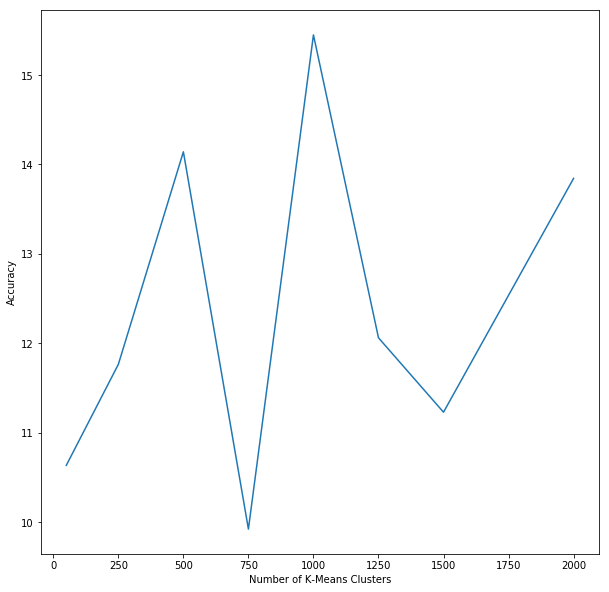

In [29]:
plot_kmeans(svm_results)

### Plot ROC

Clusters:50 Accuracy:10.63576945929887


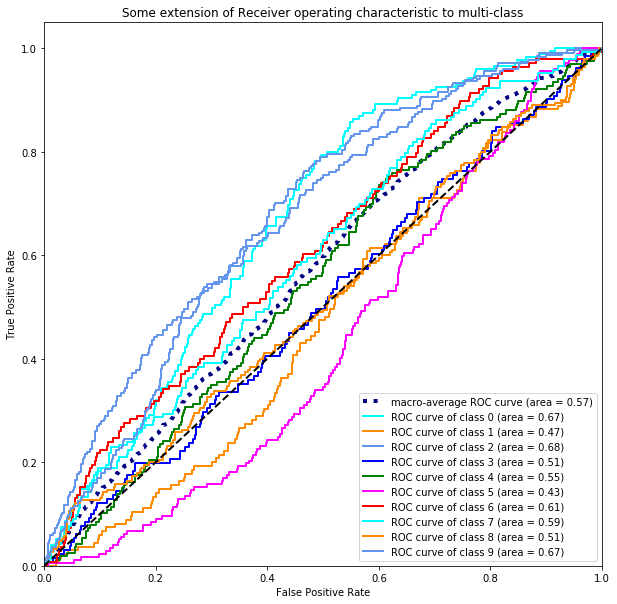

Clusters:250 Accuracy:11.76470588235294


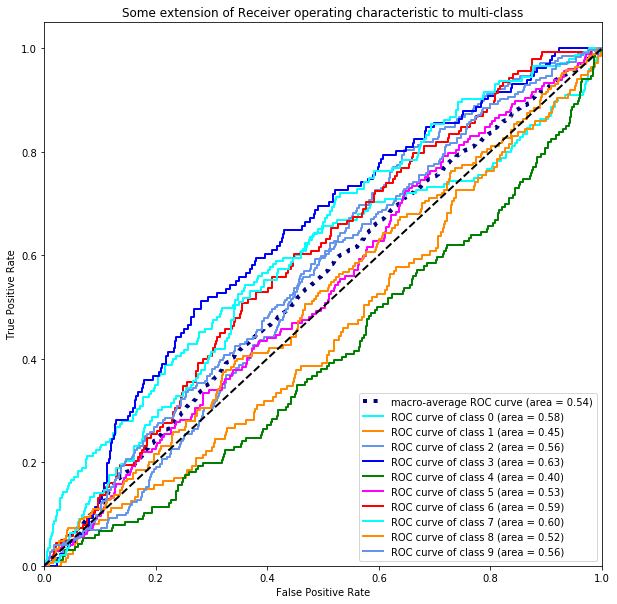

Clusters:500 Accuracy:14.14141414141414


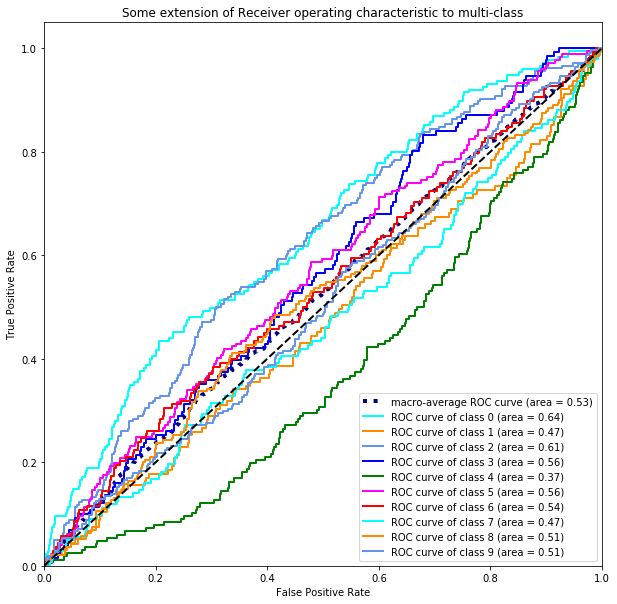

Clusters:750 Accuracy:9.92275698158051


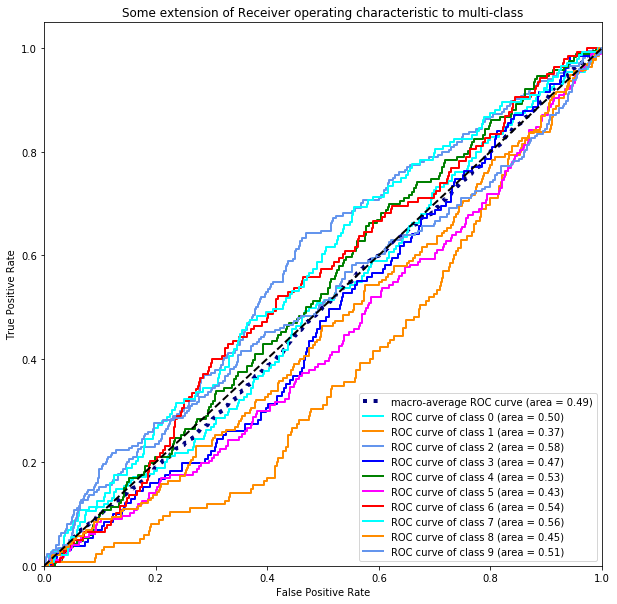

Clusters:1000 Accuracy:15.448603683897803


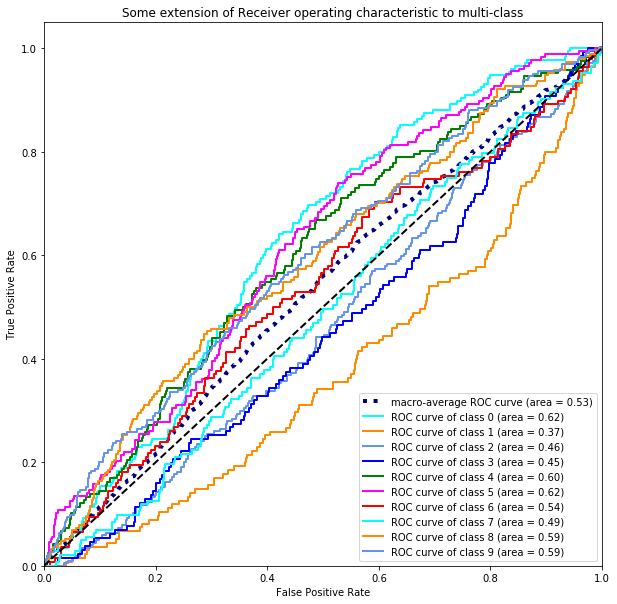

Clusters:1250 Accuracy:12.06179441473559


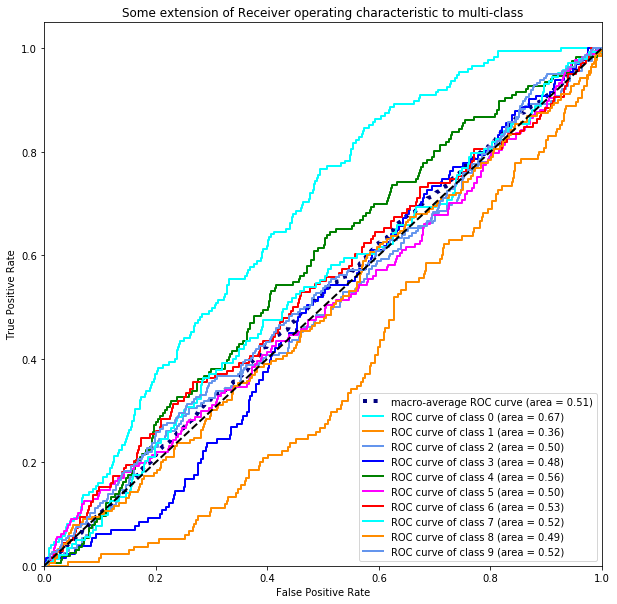

Clusters:1500 Accuracy:11.229946524064172


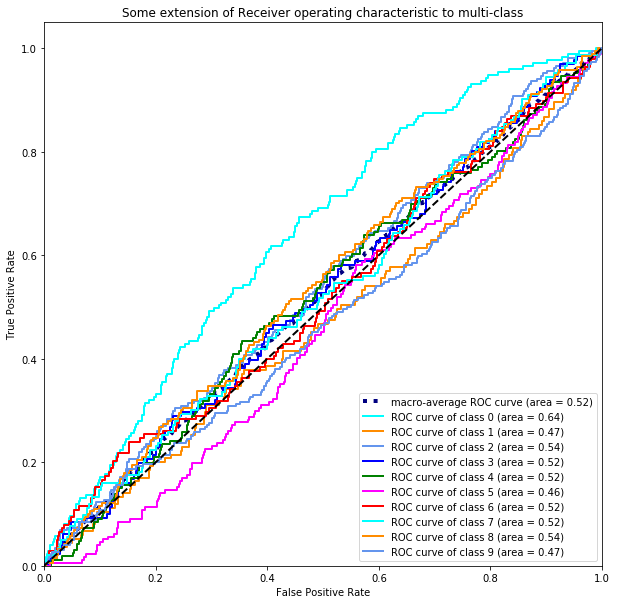

Clusters:2000 Accuracy:13.844325609031491


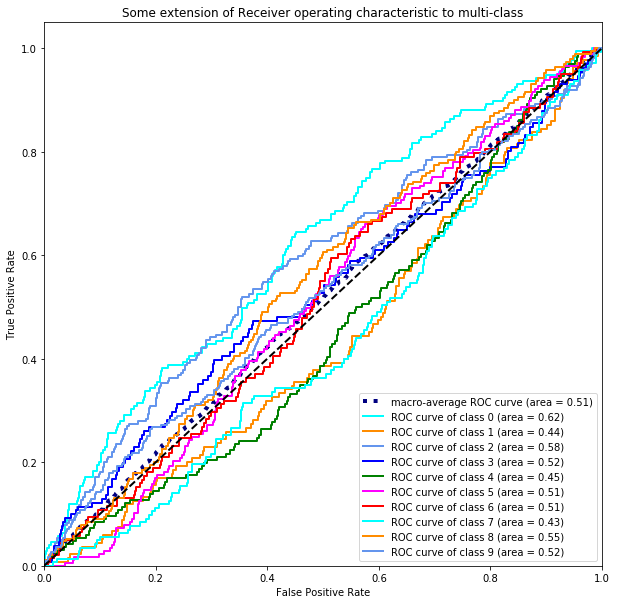

In [30]:
plot_results(svm_results)

In [31]:
logistic_results = kmeans_grid_accuracy_and_roc(processed_train_data=processed_train_data,
                                           test=test,svm_classifier=False,logistic_classifier=True)

Histogram Generated
Cluster:: 50, Accuracy :: 15.62685680332739

Histogram Generated
Cluster:: 250, Accuracy :: 11.467617349970292



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 500, Accuracy :: 13.368983957219251



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=750. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 750, Accuracy :: 14.616755793226382



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 1000, Accuracy :: 14.43850267379679



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1250. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 1250, Accuracy :: 12.4777183600713



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1500. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 1500, Accuracy :: 12.774806892453952



/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)


Histogram Generated
Cluster:: 2000, Accuracy :: 10.219845513963161



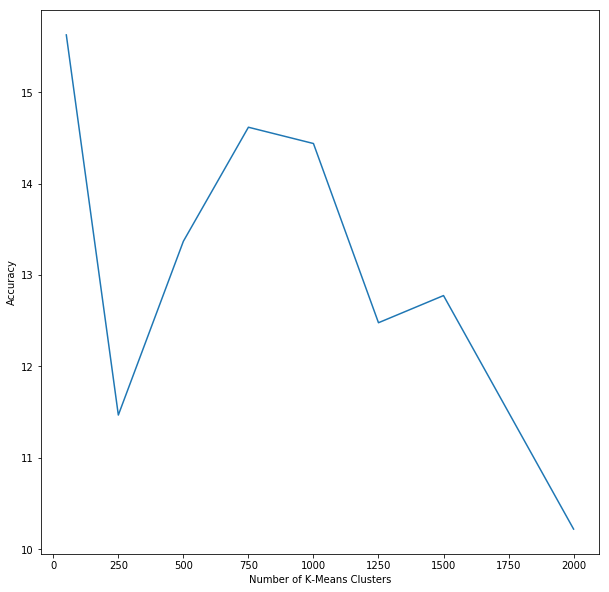

In [33]:
plot_kmeans(logistic_results)

Clusters:50 Accuracy:15.62685680332739


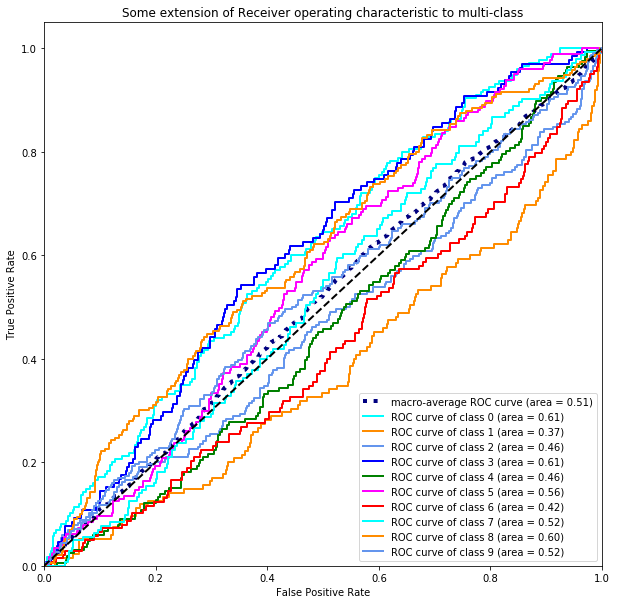

Clusters:250 Accuracy:11.467617349970292


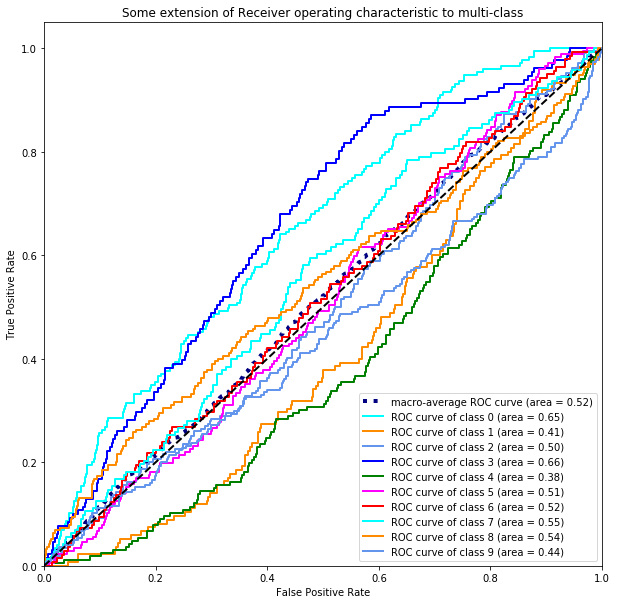

Clusters:500 Accuracy:13.368983957219251


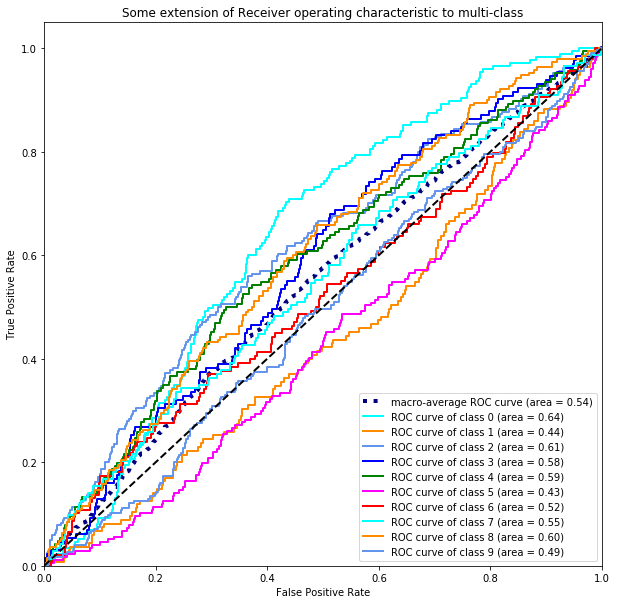

Clusters:750 Accuracy:14.616755793226382


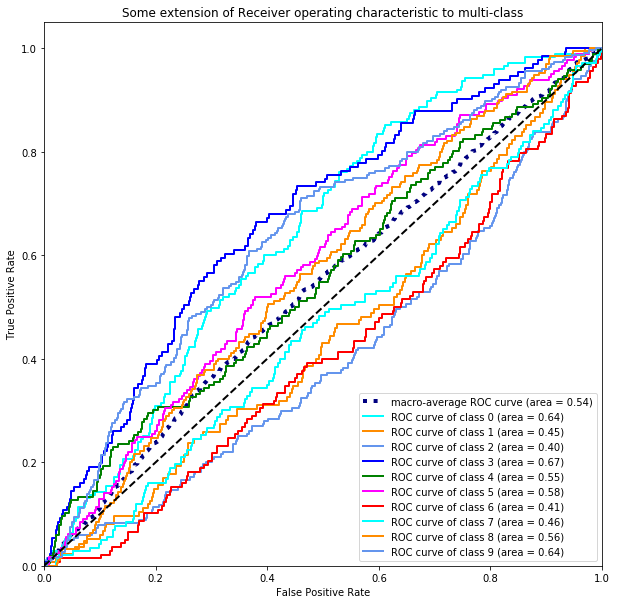

Clusters:1000 Accuracy:14.43850267379679


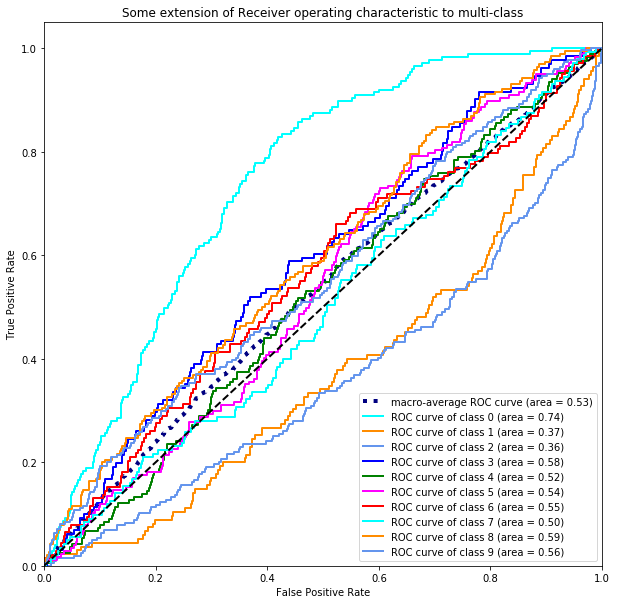

Clusters:1250 Accuracy:12.4777183600713


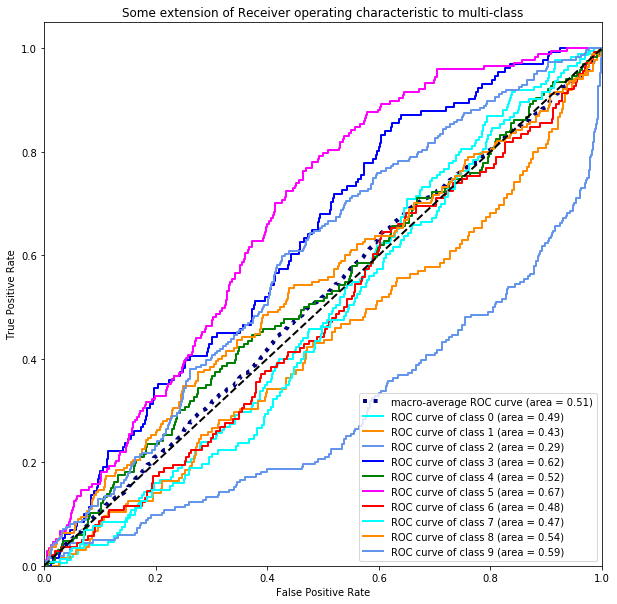

Clusters:1500 Accuracy:12.774806892453952


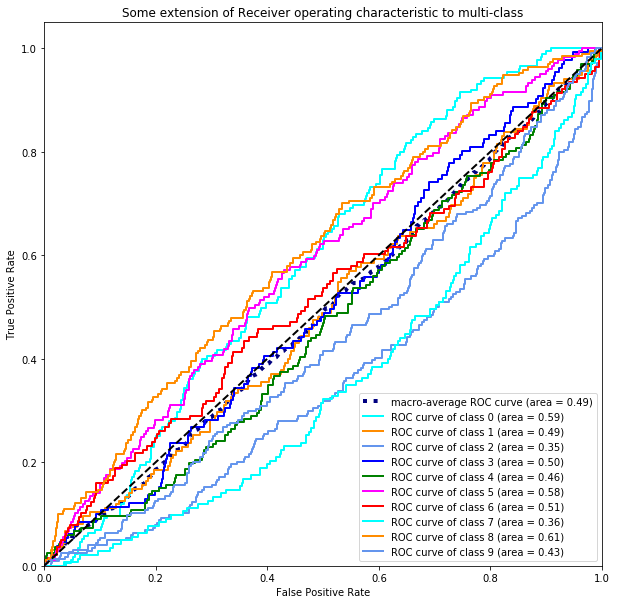

Clusters:2000 Accuracy:10.219845513963161


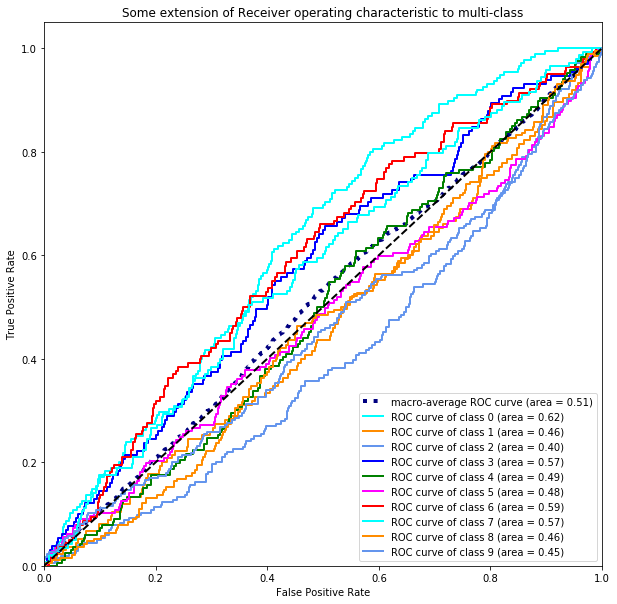

In [34]:
plot_results(logistic_results)